In [1]:

%pprint

Pretty printing has been turned OFF



---
# Load needed libraries and functions

In [2]:

%matplotlib inline
from datetime import datetime
from neo4j.exceptions import ServiceUnavailable
import humanize
import os
import sys
import time
import warnings
import winsound

warnings.filterwarnings('ignore')
duration = 1000  # milliseconds
freq = 880  # Hz

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

t0 = t1 = time.time()

# Get the Neo4j driver
from storage import Storage
s = Storage(
    data_folder_path=os.path.abspath('../data'),
    saves_folder_path=os.path.abspath('../saves')
)

from ha_utils import HeaderAnalysis
ha = HeaderAnalysis(s=s, verbose=False)

from scrape_utils import WebScrapingUtilities
wsu = WebScrapingUtilities(
    s=s,
    secrets_json_path=os.path.abspath('../data/secrets/jh_secrets.json')
)
uri = wsu.secrets_json['neo4j']['connect_url']
user =  wsu.secrets_json['neo4j']['username']
password = wsu.secrets_json['neo4j']['password']

# Get the neo4j object
from cypher_utils import CypherUtilities
cu = CypherUtilities(
    uri=uri, user=user, password=password, driver=None, s=s, ha=ha
)

try:
    version_str = cu.driver.get_server_info().agent
    print(f'======== {version_str} ========')
except ServiceUnavailable as e:
    print('You need to start Neo4j as a console')
    raise
except Exception as e:
    print(f'{e.__class__}: {str(e).strip()}')

from hc_utils import HeaderCategories
hc = HeaderCategories(cu=cu, verbose=False)

from lr_utils import LrUtilities
lru = LrUtilities(ha=ha, cu=cu, hc=hc, verbose=False)

from crf_utils import CrfUtilities
crf = CrfUtilities(ha=ha, hc=hc, cu=cu, lru=lru, verbose=True)

from section_utils import SectionUtilities
su = SectionUtilities(s=s, ha=ha, wsu=wsu, cu=cu, crf=crf, verbose=False)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Utility libraries created in {duration_str}')

======== Neo4j/4.4.7 ========
Utility libraries created in 12 seconds


In [4]:

# Keep the total creation time to less than one hour by adjusting the sampling strategy limit
# I have 47,686 labeled parts of speech in here
# Parts-of-speech logistic regression elements built in 2 hours, 3 minutes and 10 seconds
t1 = time.time()
if not (hasattr(lru, 'POS_PREDICT_PERCENT_FIT_DICT') or crf.is_flask_running()):
    lru.build_pos_logistic_regression_elements(sampling_strategy_limit=None, verbose=True)#6_400
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Parts-of-speech logistic regression elements built in {duration_str}')

Parts-of-speech logistic regression elements built in 2 seconds


In [5]:

# Check if the crf has built its parts-of-speech classifier
t1 = time.time()
if not hasattr(crf, 'pos_crf_predict_single'):# or crf.is_flask_running())
    crf.build_pos_conditional_random_field_elements(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Parts-of-speech CRF elements built in {duration_str}')

I have 46,569 labeled parts of speech in here
Parts-of-speech CRF elements built in 19 minutes and 38 seconds


In [6]:

# Check if the lru has built its is-qualified classifier
t1 = time.time()
if not hasattr(lru, 'ISQUALIFIED_LR'):
    lru.build_isqualified_logistic_regression_elements(sampling_strategy_limit=5_000, verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Is-qualified LR elements built in {duration_str}')

I have 352,288 is-qualified vocabulary keys in here
Is-qualified LR elements built in 1 minute and 49 seconds


In [7]:

# Check if the lru has retrained its is-header classifier
t1 = time.time()
if not hasattr(lru, 'ISHEADER_PREDICT_PERCENT_FIT'):
    if not hasattr(lru, 'ISHEADER_LR'):
        lru.build_isheader_logistic_regression_elements(verbose=True)
    lru.retrain_isheader_classifier(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Is-header classifier retrained in {duration_str}')

I have 81,585 hand-labeled header htmls in here
Is-header classifier retrained in 25 seconds


In [8]:

winsound.Beep(freq, duration)
print(f'Last run on {datetime.now()}')

Last run on 2023-03-16 07:01:51.072351



---
# Training

In [475]:

# You need to run this again if you changed the qualification dictionary in another notebook
t1 = time.time()

# Keep the total retraining time to less than two minutes by adjusting the sampling strategy limit
lru.sync_basic_quals_dict(sampling_strategy_limit=None, verbose=False)

lru.retrain_isqualified_classifier(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Is-qualified classifer retrained in {duration_str}')

I have 12,435 hand-labeled qualification strings in here
I have 416,039 is-qualified vocabulary keys in here
Is-qualified classifer retrained in 1 minute and 30 seconds



---
# Inference


                MATCH (fn:FileNames {file_name: "c31199256bb7c825_Data_Analytics_Lead_Principal_Remote_Indeed_com.html"})
                SET fn.percent_fit = "0.631578947368421";

Basic Qualifications for Data Scientist Remote:
*quals_list[0] = "<p>· Experience with Python, Pandas, Jupyter notebooks.</p>" (1.0)
*quals_list[1] = "<p>· Oracle/SQL Server/RedShift.</p>" (0.0341)
*quals_list[2] = "<p>· Excel workbooks.</p>" (1.0)
*quals_list[3] = "<p>· Bachelor's degree in a quantitative field like Computer Science, Engineering, Statistics, Mathematics or a related field required.</p>" (1.0)
*quals_list[4] = "<p>· Experience in AWS (Amazon Web Services)</p>" (0.0)
*quals_list[5] = "<p>· Experience with SQL and databases.</p>" (1.0)
*quals_list[6] = "<p>· Strong Excel and MS Office skills.</p>" (1.0)
71.43%

hunting_df.loc[7948, 'percent_fit'] = (000+000+000+000+000+000+000)/7
7946/7954 = 99.9% completed
Minimum-requirements-met percentages estimated in 9 minutes and 54 seconds


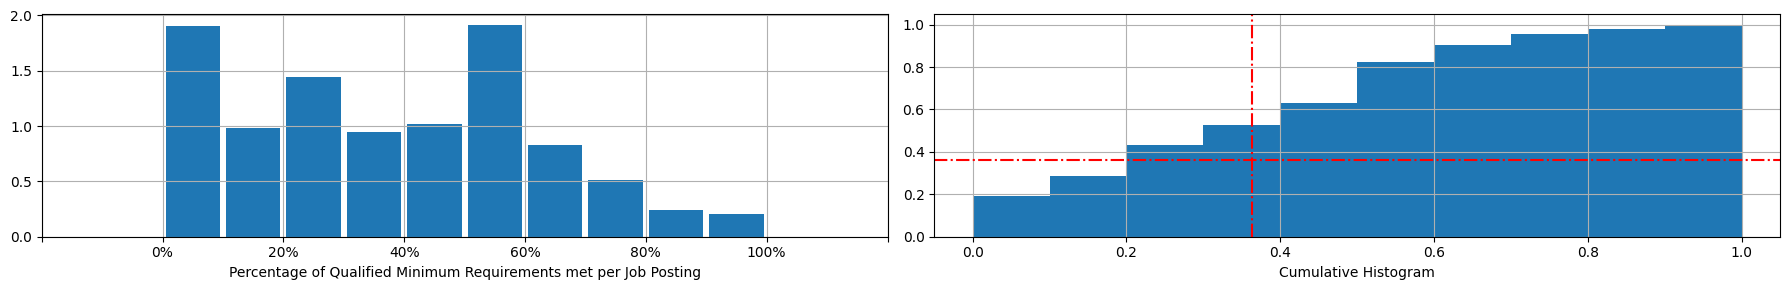

In [476]:

t1 = time.time()

# Loop through all the unset %fit values, set them if you can, break for help if you can't
quals_list, file_name = lru.infer_from_hunting_dataframe(su=su)

# Display as histogram
lru.display_hunting_dataframe_as_histogram()

# Show how long it took
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
winsound.Beep(freq, duration)
print(f'Minimum-requirements-met percentages estimated in {duration_str}')

In [ ]:

# Restarting the kernal and getting to this cell took 26 minutes and 52 seconds
duration_str = humanize.precisedelta(time.time() - t0, minimum_unit='seconds', format='%0.0f')
print(f'Restarting the kernel and getting to this cell took {duration_str}')
raise

In [477]:

# Manually label the unscored qual
qualification_str = quals_list[0]
print(qualification_str); basic_quals_dict = s.load_object('basic_quals_dict')
print(str(basic_quals_dict[qualification_str]) + '\n' if(qualification_str in basic_quals_dict) else '', end='')
basic_quals_dict[qualification_str] = 1
s.store_objects(basic_quals_dict=basic_quals_dict)

<p>· Experience with Python, Pandas, Jupyter notebooks.</p>
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_dict.pkl



----
## Fix Parts-of-Speech and Quals for this posting

In [478]:

import os

file_path = os.path.join(cu.SAVES_HTML_FOLDER, file_name)
if os.path.isfile(file_path):
    child_strs_list = ha.get_child_strs_from_file(file_name=file_name)
    cu.ensure_filename(file_name, verbose=False)
    cu.populate_from_child_strings(child_strs_list, file_name, verbose=False)
    print(file_name)
    child_tags_list = ha.get_child_tags_list(child_strs_list)
    is_header_list = []
    for is_header, child_str in zip(ha.get_is_header_list(child_strs_list), child_strs_list):
        if is_header is None:
            probs_list = lru.ISHEADER_PREDICT_PERCENT_FIT(child_str)
            idx = probs_list.index(max(probs_list))
            is_header = [True, False][idx]
        is_header_list.append(is_header)
    feature_dict_list = hc.get_feature_dict_list(child_tags_list, is_header_list, child_strs_list)
    feature_tuple_list = []
    for feature_dict in feature_dict_list:
        feature_tuple_list.append(hc.get_feature_tuple(feature_dict, pos_lr_predict_single=None, pos_crf_predict_single=None))
    crf_list = crf.CRF.predict_single(crf.sent2features(feature_tuple_list))

22d9249fa5bfa5f6_Data_Scientist_Remote_Indeed_com.html


In [479]:

db_pos_list = []
for navigable_parent in child_strs_list:
    db_pos_list = cu.append_parts_of_speech_list(navigable_parent, pos_list=db_pos_list)
pos_list, indices_list = su.visualize_basic_quals_section(crf_list, child_strs_list, db_pos_list=db_pos_list, verbose=True)
winsound.Beep(freq, duration)

['H-O', 'O-O', 'O-IP', 'H-JD', 'O-JD', 'O-IP', 'O-JD', 'O-IP', 'O-IP', 'O-IP', 'H-JD', 'O-JD', 'O-SP', 'H-RQ', 'H-PQ', 'H-PQ', 'H-SP', 'O-IP', 'O-SP', 'O-SP', 'O-SP', 'O-SP', 'H-TS', 'O-JT', 'O-OL', 'O-TS', 'O-RQ', 'H-TS', 'O-TS', 'O-TS', 'O-RQ', 'O-TS', 'O-O', 'O-RQ', 'O-TS', 'O-TS', 'O-TS', 'H-TS', 'H-PQ', 'O-RQ', 'H-ER', 'O-ER', 'H-PQ', 'O-RQ', 'O-RQ', 'O-PQ', 'O-RQ', 'O-JD', 'H-SP', 'H-SP', 'O-SP', 'O-SP', 'O-SP', 'O-SP', 'H-JD', 'O-JD', 'O-JD', 'H-RQ', 'O-PQ', 'O-PQ', 'O-OL', 'O-SP', 'H-O', 'O-O', 'O-O', 'H-TS', 'O-O', 'H-O', 'O-PD']
[26, 30, 33, 39, 41]


[26, 30, 33, 39, 41]


In [ ]:
raise

In [472]:

# Display the context of an individual child string
idx = 47
print(indices_list); child_str = child_strs_list[idx]; pos_symbol = pos_list[idx]; basic_quals_dict = s.load_object('basic_quals_dict')
print(str(basic_quals_dict[child_str]) + '\n' if(child_str in basic_quals_dict) else '', end='')
print(f'{idx} {pos_symbol}) {child_str}')

[34, 37, 38, 41, 42]
47 H-CS) <b>About Us:</b>


In [470]:

# Hand-label this particular child string in the quals dictionary
basic_quals_dict = s.load_object('basic_quals_dict')
basic_quals_dict[child_str] = 1
s.store_objects(basic_quals_dict=basic_quals_dict); print(f'"{child_str}" in basic_quals_dict: {basic_quals_dict[child_str]}')

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_dict.pkl
"<li>Experienced with tools such as these: AWS (server &amp; serverless services), Ansible or (Preferred) Terraform, CloudFormations, (Preferred) Python, Jenkins, (Preferred) GitHub GitOps, (Preferred) Security scanning tools (Nessus, BurpSuite, Netsparker, OWASP, etc.), IaC (Infrastructure as Code) techniques for the full stack of Dev/Data Analytics, QA tools below. Potentially others…Dev/Data Analytics, QA - SAS Viya, hadoop, airflow, AWS EMR hbase, Quicksight, Apache Ranger/Knox, AWS IAM, Ambari, Hive, Sagemaker, Zepelin, Jupyter, python stack, Databricks, Lustre, and potentially others)</li>" in basic_quals_dict: 1


In [471]:

def do_cypher_tx(tx, navigable_parent, verbose=False):
    cypher_str = '''
        MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
        SET
            np.is_header = 'False',
            np.is_task_scope = 'False',
            np.is_minimum_qualification = 'False',
            np.is_preferred_qualification = 'True',
            np.is_educational_requirement = 'False',
            np.is_legal_notification = 'False',
            np.is_other = 'False',
            np.is_corporate_scope = 'False',
            np.is_job_title = 'False',
            np.is_office_location = 'False',
            np.is_job_duration = 'False',
            np.is_supplemental_pay = 'False',
            np.is_interview_procedure = 'False',
            np.is_posting_date = 'False'
        ''' + cu.return_everything_str + ';'
    results_list = tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
    
    return [dict(record.items()) for record in results_list]
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)
row_objs_list

[{'navigable_parent': '<li>Experienced with tools such as these: AWS (server &amp; serverless services), Ansible or (Preferred) Terraform, CloudFormations, (Preferred) Python, Jenkins, (Preferred) GitHub GitOps, (Preferred) Security scanning tools (Nessus, BurpSuite, Netsparker, OWASP, etc.), IaC (Infrastructure as Code) techniques for the full stack of Dev/Data Analytics, QA tools below. Potentially others…Dev/Data Analytics, QA - SAS Viya, hadoop, airflow, AWS EMR hbase, Quicksight, Apache Ranger/Knox, AWS IAM, Ambari, Hive, Sagemaker, Zepelin, Jupyter, python stack, Databricks, Lustre, and potentially others)</li>', 'is_header': 'False', 'is_task_scope': 'False', 'is_qualification': None, 'is_minimum_qualification': 'False', 'is_preferred_qualification': 'True', 'is_legal_notification': 'False', 'is_job_title': 'False', 'is_office_location': 'False', 'is_job_duration': 'False', 'is_supplemental_pay': 'False', 'is_educational_requirement': 'False', 'is_interview_procedure': 'False', 

In [473]:

# Show what's in the database already for this html string
def do_cypher_tx(tx, navigable_parent, verbose=False):
    cypher_str = '''
        MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
        ''' + cu.return_everything_str + ';'
    results_list = tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})

    return [dict(record.items()) for record in results_list]
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)
row_objs_list

[{'navigable_parent': '<b>About Us:</b>', 'is_header': 'True', 'is_task_scope': 'False', 'is_qualification': None, 'is_minimum_qualification': 'False', 'is_preferred_qualification': 'False', 'is_legal_notification': 'False', 'is_job_title': 'False', 'is_office_location': 'False', 'is_job_duration': 'False', 'is_supplemental_pay': 'False', 'is_educational_requirement': 'False', 'is_interview_procedure': 'False', 'is_corporate_scope': 'True', 'is_posting_date': 'False', 'is_other': 'False'}]


----
## Maintenance

In [429]:

# Remove this particular child string from the quals dictionary and database
basic_quals_dict = s.load_object('basic_quals_dict')
child_str = child_strs_list[idx]
basic_quals_dict.pop(child_str, None)
# basic_quals_dict[child_str] = 0
s.store_objects(basic_quals_dict=basic_quals_dict)
print(f'"{child_str}" in basic_quals_dict: {child_str in basic_quals_dict}')
def do_cypher_tx(tx, qualification_str, verbose=False):
    cypher_str = '''
        MATCH (qs:QualificationStrings {qualification_str: $qualification_str})
        DETACH DELETE qs;
        '''
    results_list = tx.run(query=cypher_str, parameters={'qualification_str': qualification_str})

    return [dict(record.items()) for record in results_list]
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(do_cypher_tx, qualification_str=child_str, verbose=False)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_dict.pkl
"<li>Provide/write end-to-end engineering and developer documentation.</li>" in basic_quals_dict: False


In [ ]:

# Remove file name from database
for file_name in ['4463189_0_Accenture_Acquisitions_Field_Telecom_Technician_4463189.html', '4463189_0_Accenture_Acquisitions_Field_Telecom_Technician_4463189.html',
                  '4597100_0_CHICAGO_PACIFIC_FOUNDERS_Release_Test_Lead.html', '4597100_0_CHICAGO_PACIFIC_FOUNDERS_Release_Test_Lead.html', '4597664_0_ELEVANCE_HEALTH_INC_Application_Developer_Angular.html',
                  '4597664_0_ELEVANCE_HEALTH_INC_Application_Developer_Angular.html', '4597665_0_ELEVANCE_HEALTH_INC_Application_Developer_React_Native.html',
                  '4597665_0_ELEVANCE_HEALTH_INC_Application_Developer_React_Native.html', '4651197_0_BANK_OF_AMERICA_NFRR_Lead_Developer_PySpark.html', '4651197_0_BANK_OF_AMERICA_NFRR_Lead_Developer_PySpark.html',
                  '4666631_0_APPLE_INC_Fitness_Technician_4666631.html', '4666631_0_APPLE_INC_Fitness_Technician_4666631.html', '4669397_0_STATE_OF_MISSOURI_Cloud_Interface_Specialist_2.html',
                  '4669397_0_STATE_OF_MISSOURI_Cloud_Interface_Specialist_2.html', '4669440_0_STATE_OF_MISSOURI_Middleware_Developer_8.html', '4669440_0_STATE_OF_MISSOURI_Middleware_Developer_8.html',
                  '4669456_0_STATE_OF_MISSOURI_Cloud_Interface_Specialist_4_HCM.html', '4669456_0_STATE_OF_MISSOURI_Cloud_Interface_Specialist_4_HCM.html', '4671668_0_Hess_Corporation_Solution_Architect_AFOF.html',
                  '4671668_0_Hess_Corporation_Solution_Architect_AFOF.html', '4705125_0_HCSC_Sales_PM_Manager.html', '4705125_0_HCSC_Sales_PM_Manager.html', '4705126_0_HCSC_Implementation_Workstream_Lead.html',
                  '4705126_0_HCSC_Implementation_Workstream_Lead.html', '4705138_0_HCSC_Intake_Lead.html', '4705138_0_HCSC_Intake_Lead.html', '4707608_0_Accenture_Acquisitions_Driver_4707608.html',
                  '4707608_0_Accenture_Acquisitions_Driver_4707608.html', '4711838_0_BANK_OF_AMERICA_PEGA_Architect_Lead.html', '4711838_0_BANK_OF_AMERICA_PEGA_Architect_Lead.html',
                  '4717092_0_SYNCHRONY_FINANCIAL_Sr_ETLAbinitio_Developer_GCP_SLS.html', '4717092_0_SYNCHRONY_FINANCIAL_Sr_ETLAbinitio_Developer_GCP_SLS.html', '4722966_0_GOOGLE_FLEX_Manual_Device_Test_Engineer.html',
                  '4722966_0_GOOGLE_FLEX_Manual_Device_Test_Engineer.html', '4725283_0_NORFOLK_SOUTHERN_CORPORATION_Customer_Master_Architecture_Governance_Delivery_Lead.html',
                  '4725283_0_NORFOLK_SOUTHERN_CORPORATION_Customer_Master_Architecture_Governance_Delivery_Lead.html', '4725410_0_BERKSHIRE_HATHAWAY_ENERGY_Azure_Integration_Lead_Copy_01.html',
                  '4725410_0_BERKSHIRE_HATHAWAY_ENERGY_Azure_Integration_Lead_Copy_01.html', '4725579_0_STERICYCLE_INC_Performance_Test_Lead.html', '4725579_0_STERICYCLE_INC_Performance_Test_Lead.html',
                  '4729260_0_BANK_OF_AMERICA_Software_Development_Engineer_in_Test_SDET.html', '4729260_0_BANK_OF_AMERICA_Software_Development_Engineer_in_Test_SDET.html',
                  '4730061_0_STATE_FARM_INSURANCE_Full_Stack_Developer.html', '4730061_0_STATE_FARM_INSURANCE_Full_Stack_Developer.html', '4732279_0_GOOGLE_BII_Architect_Copy_01.html',
                  '4732279_0_GOOGLE_BII_Architect_Copy_01.html', '4732380_0_JONES_FINANCIAL_COMPANIES_L_L_L_P_Scrum_Master.html', '4732380_0_JONES_FINANCIAL_COMPANIES_L_L_L_P_Scrum_Master.html',
                  '4732381_0_JONES_FINANCIAL_COMPANIES_L_L_L_P_Scrum_Master_Copy_01.html', '4732381_0_JONES_FINANCIAL_COMPANIES_L_L_L_P_Scrum_Master_Copy_01.html', '4732575_0_CLOROX_SAP_QM_MOC_Consultant.html',
                  '4732575_0_CLOROX_SAP_QM_MOC_Consultant.html', '4732633_0_KAISER_Vendor_Evaluation_Specialist.html', '4732633_0_KAISER_Vendor_Evaluation_Specialist.html',
                  '4736020_0_AMAZON_COM_INC_Super_Pod_QA_Lead.html', '4736020_0_AMAZON_COM_INC_Super_Pod_QA_Lead.html', '4736021_0_AMAZON_COM_INC_Super_Pod_QA_Lead_Copy_01.html',
                  '4736021_0_AMAZON_COM_INC_Super_Pod_QA_Lead_Copy_01.html']:
    cu.delete_filename_node(file_name, verbose=True)